<h4>I used Claude, Anthropic's model to help with the code portion of this assignment.</h4>
<h4>I used Copilot for help understanding these concepts.</h4>

<h3>1) Collect data from a reputable source in order use both a simple regression and multiple regression to make prediction and generate prediction intervals in a Colab notebook. You can collect multiple independent variables, or you can "make" the extra independent variable by using a time trend like the video, interactions, or categorical variables. Do not use simulated data for this assignment. Motivate your analysis by explaining why someone might be interested in predicting the dependent variable you use. Please reach out to me if you need to brainstorm data to collect. Come up with some interesting sets of independent variables to make predictions with, and present both the point prediction and associated prediction interval.</h3>


<p>I found a dataset a kaggle user put together by scraping online forms for job postings related to data science.</p>
<a href="https://www.kaggle.com/datasets/elahehgolrokh/data-science-job-postings-with-salaries-2025">2025 Data Science Job Postings</a>

<ul>
<li>job_title → The main keyword in the title of the posted position (e.g., Data Scientist, ML Engineer).
</li>
<li>seniority_level → Seniority of the role (e.g., Junior, Senior, Lead).
</li>
<li>status → Work arrangement type (Remote, Hybrid, On-site).
</li>
<li>company → Anonymized company identifier.
</li>
<li>location → Job location(s) mentioned in the posting.
</li>
<li>post_date → When the job posting was listed.
</li>
<li>headquarter → Location of the company’s headquarters.
</li>
<li>industry → Industry sector of the company (e.g., Finance, Technology).
</li>
<li>ownership → Ownership type (e.g., Public, Private).
</li>
<li>company_size → Number of employees in the company.
</li>
<li>revenue → Reported revenue of the company (if available).
</li>
<li>salary → Annual salary in Euro, expressed as min-max or a single value
</li>
<li>skills → Extracted list of required or preferred skills (e.g., Python, SQL, Spark).</li>
</ul>

<p>We all have a job for one reason and that's money. If you don't work for money you're a lucky person, but for most, money is why we show up to our jobs.</p>
<p>Due to this reason I thought it would be intresting to make my dependent variable salary for data science jobs. </p>

In [385]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [386]:
df = pd.read_csv('../datasets/assignment8/data_science_job_posts_2025.csv')

In [387]:
# Sample exchange rate (you can update this dynamically)
EUR_TO_USD = 1.17

def convert_revenue(value):
    value = str(value)  # Ensure it's a string
    match = re.match(r'€([\d\.]+)([MBT])', value)
    if match:
        num, unit = match.groups()
        multiplier = {'M': 1e6, 'B': 1e9, 'T': 1e12}[unit]
        usd_value = float(num) * multiplier * EUR_TO_USD
        return f"${usd_value:,.2f}"
    return value  # Return original if not matching

def convert_salary(value):
    value = str(value)  # Ensure it's a string
    parts = re.findall(r'€[\d,]+', value)
    if parts:
        converted = []
        for part in parts:
            num = float(part.replace('€', '').replace(',', ''))
            usd = num * EUR_TO_USD
            converted.append(f"${usd:,.0f}")
        return " - ".join(converted)
    return value

df['revenue'] = df['revenue'].fillna("").apply(convert_revenue)
df['salary'] = df['salary'].fillna("").apply(convert_salary)
df = df[df['company_size'].astype(str).str.match(r'^[\d,]+$')] # I lost 40 rows since company size had erroneous euro signs and I didn't want to regex them...

df = df.drop('company', axis=1)

df.head(5)


,job_title,seniority_level,status,location,post_date,headquarter,industry,ownership,company_size,revenue,salary,skills
1,data scientist,lead,hybrid,"Fort Worth, TX . Hybrid",15 days ago,"Detroit, MI, US",Manufacturing,Public,"155,030","$59,787,000,000.00","$138,918","['spark', 'r', 'python', 'sql', 'machine learn..."
2,data scientist,senior,on-site,"Austin, TX . Toronto, Ontario, Canada . Kirkla...",a month ago,"Redwood City, CA, US",Technology,Public,"25,930","$39,546,000,000.00","$111,135 - $186,684","['aws', 'git', 'python', 'docker', 'sql', 'mac..."
3,data scientist,senior,hybrid,"Chicago, IL . Scottsdale, AZ . Austin, TX . Hy...",8 days ago,"San Jose, CA, US",Technology,Public,"34,690","$95,600,700,000.00","$131,972 - $227,450","['sql', 'r', 'python']"
4,data scientist,NaN,on-site,On-site,3 days ago,"Stamford, CT, US",Finance,Private,"1,800",Private,"$133,581 - $267,154",[]
5,data scientist,lead,NaN,"New York, NY",3 months ago,"New York, NY, US",Technology,Private,150,"$2,527,200,000.00","$229,754 - $293,869","['scikit-learn', 'python', 'scala', 'sql', 'ma..."


In [388]:
# prints me unique id in a column
for val in df['job_title'].unique():
    print(val)

print('\n')
# df.nunique()
# df.info()
print( df.info(), df.nunique())

data scientist
machine learning engineer
nan
data analyst
data engineer


<class 'pandas.core.frame.DataFrame'>
Index: 905 entries, 1 to 943
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_title        902 non-null    object
 1   seniority_level  845 non-null    object
 2   status           650 non-null    object
 3   location         903 non-null    object
 4   post_date        905 non-null    object
 5   headquarter      905 non-null    object
 6   industry         905 non-null    object
 7   ownership        873 non-null    object
 8   company_size     905 non-null    object
 9   revenue          905 non-null    object
 10  salary           905 non-null    object
 11  skills           905 non-null    object
dtypes: object(12)
memory usage: 91.9+ KB
None job_title            4
seniority_level      4
status               3
location           411
post_date           42
headquarter        194
industry   

salary = beta_0 + beta_1*industry + beta_2*job_title + beta_3*location + beta_4*company_size... every single column seems useful. I just gotta preprocess it. But Now I know that salary is my dependent variable.


In [389]:

# --- Helper functions ---

def clean_salary(salary_str):
    """Convert salary column (single value or range) to numeric midpoint."""
    if pd.isna(salary_str):
        return np.nan
    # Remove dollar signs, commas
    s = salary_str.replace("$", "").replace(",", "")
    # Handle ranges
    if "-" in s:
        low, high = s.split("-")
        return (float(low) + float(high)) / 2
    try:
        return float(s)
    except:
        return np.nan

def clean_revenue(rev_str):
    """Convert revenue string with $ and commas to numeric float, or flag known categories."""
    if pd.isna(rev_str):
        return np.nan

    # Handle known non-numeric labels
    rev_str = rev_str.strip().lower()
    if "private" in rev_str:
        return -1  # Flag for private companies
    elif "public" in rev_str:
        return -2  # Flag for public companies
    elif "education" in rev_str:
        return -3  # Flag for education sector
    elif "nonprofit" in rev_str:
        return -4  # Flag for education sector

    # Remove dollar signs and commas
    s = rev_str.replace("$", "").replace(",", "")
    try:
        return float(s)
    except:
        return np.nan
    
def extract_revenue_type(rev_str):
    if pd.isna(rev_str):
        return "Unknown"
    rev_str = rev_str.strip().lower()
    if "private" in rev_str:
        return "Private"
    elif "public" in rev_str:
        return "Public"
    elif "education" in rev_str:
        return "Education"
    elif "nonprofit" in rev_str:
        return "Nonprofit"
    else:
        return "Numeric"

def days_since_posting(post_date_str):
    """Convert relative dates like '15 days ago', 'a month ago', '2 years ago' to days."""
    if pd.isna(post_date_str):
        return np.nan
    text = post_date_str.lower()

    # Look for a number
    nums = re.findall(r'\d+', text)

    if "day" in text and nums:
        return int(nums[0])
    elif "day" in text:
        return 1  # "a day ago"
    elif "month" in text and nums:
        return int(nums[0]) * 30
    elif "month" in text:
        return 30  # "a month ago"
    elif "year" in text and nums:
        return int(nums[0]) * 365
    elif "year" in text:
        return 365  # "a year ago"
    else:
        return np.nan
    
def extract_state(location_str):
    """Extract state (US) or country for simplification."""
    if pd.isna(location_str):
        return None
    # Take the first part before a '.' if multiple locations
    loc = location_str.split(".")[0].strip()
    # Grab last part (state abbreviation or country)
    parts = loc.split(",")
    if len(parts) > 1:
        return parts[-1].strip()
    return loc.strip()

def midpoint_company_size(size_val):
    if pd.isna(size_val):
        return np.nan
    try:
        # Remove commas
        clean_val = str(size_val).replace(",", "")
        return float(clean_val)
    except:
        if "-" in str(size_val):
            low, high = str(size_val).replace(",", "").split("-")
            return (float(low) + float(high)) / 2
    return np.nan


In [390]:

# Salary -> numeric
df["salary_num"] = df["salary"].apply(clean_salary)

# Revenue -> numeric
df["revenue_num"] = df["revenue"].apply(clean_revenue)

# captures all of the different types of revenue strings since nearly 400 rows were categorical and not a numerical amount.
df["revenue_type"] = df["revenue"].apply(extract_revenue_type)

# Company size -> numeric
df["company_size_num"] = df["company_size"].apply(midpoint_company_size)

# Post date -> numeric days
df["days_since_post"] = df["post_date"].apply(days_since_posting)

# Location -> state/country
df["job_state"] = df["location"].apply(extract_state)

# Headquarter -> state/country
df["hq_state"] = df["headquarter"].apply(extract_state)


# Skills -> turn into binary skill indicators
# Flatten list of skills
all_skills = set()
df["skills"] = df["skills"].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith("[") else [])
df["skills"].apply(lambda skill_list: all_skills.update(skill_list))
all_skills = list(all_skills)

for skill in all_skills:
    df[f"skill_{skill.lower()}"] = df["skills"].apply(lambda x: 1 if skill in x else 0)
# Define column groups
categorical_cols = ["job_title", "seniority_level", "status", "job_state", "hq_state", "industry", "ownership", "revenue_type"]
numeric_cols = ["company_size_num", "revenue_num", "days_since_post"]

# Preprocessing pipeline with imputation
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_cols),
        
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
    ],
    remainder="drop"
)

# # Full pipeline
# model = Pipeline(steps=[
#     ("preprocess", preprocessor),
#     ("regressor", LinearRegression())
# ])


In [391]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# numeric_cols = ["company_size_num", "revenue_num", "days_since_post"]

# for col in numeric_cols:
#     plt.figure(figsize=(8, 5))
#     sns.scatterplot(x=df[col], y=df["salary_num"])
#     plt.title(f"{col} vs Salary")
#     plt.xlabel(col)
#     plt.ylabel("Salary")
#     plt.tight_layout()
#     plt.show()



In [392]:
# categorical_cols = ["job_title", "seniority_level", "status", "job_state", "hq_state", "industry", "ownership"]

# for col in categorical_cols:
#     plt.figure(figsize=(12, 6))
#     sns.boxplot(x=df[col], y=df["salary_num"])
#     plt.xticks(rotation=45)
#     plt.title(f"Salary Distribution by {col}")
#     plt.tight_layout()
#     plt.show()


In [393]:
# corr = df[numeric_cols + ["salary_num"]].corr()
# sns.heatmap(corr, annot=True, cmap="coolwarm")
# plt.title("Correlation with Salary")
# plt.show()


In [394]:
# skill_cols = [col for col in df.columns if col.startswith("skill_")]

# skill_avg_salary = {
#     skill: df[df[skill] == 1]["salary_num"].mean()
#     for skill in skill_cols
# }

# # Sort and plot top 15
# top_skills = sorted(skill_avg_salary.items(), key=lambda x: x[1], reverse=True)[:15]
# skills, salaries = zip(*top_skills)

# plt.figure(figsize=(10, 6))
# sns.barplot(x=list(skills), y=list(salaries))
# plt.xticks(rotation=45)
# plt.title("Top Skills by Average Salary")
# plt.ylabel("Average Salary")
# plt.tight_layout()
# plt.show()


In [395]:
df.columns

Index(['job_title', 'seniority_level', 'status', 'location', 'post_date',
       'headquarter', 'industry', 'ownership', 'company_size', 'revenue',
       'salary', 'skills', 'salary_num', 'revenue_num', 'revenue_type',
       'company_size_num', 'days_since_post', 'job_state', 'hq_state',
       'skill_database', 'skill_pandas', 'skill_java', 'skill_scala',
       'skill_airflow', 'skill_amazon', 'skill_r', 'skill_azure',
       'skill_hadoop', 'skill_sklearn', 'skill_spark', 'skill_git',
       'skill_scikit-learn', 'skill_gcp', 'skill_powerbi', 'skill_numpy',
       'skill_docker', 'skill_opencv', 'skill_sql', 'skill_machine learning',
       'skill_pytorch', 'skill_matplotlib', 'skill_aws', 'skill_linux',
       'skill_keras', 'skill_tableau', 'skill_deep learning', 'skill_bash',
       'skill_tensorflow', 'skill_python', 'skill_scipy', 'skill_kubernetes',
       'skill_neural network'],
      dtype='object')

In [396]:
# this is where I add all of the columns from the one hot encoding.
# Drop rows where salary is NaN (cannot train without target)
df = df[~df["salary_num"].isna()].copy()

X = df[categorical_cols + numeric_cols + [col for col in df.columns if col.startswith("skill_")]]
y = df["salary_num"]

# model.fit(X, y)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 905 entries, 1 to 943
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_title               902 non-null    object 
 1   seniority_level         845 non-null    object 
 2   status                  650 non-null    object 
 3   location                903 non-null    object 
 4   post_date               905 non-null    object 
 5   headquarter             905 non-null    object 
 6   industry                905 non-null    object 
 7   ownership               873 non-null    object 
 8   company_size            905 non-null    object 
 9   revenue                 905 non-null    object 
 10  salary                  905 non-null    object 
 11  skills                  905 non-null    object 
 12  salary_num              905 non-null    float64
 13  revenue_num             905 non-null    float64
 14  revenue_type            905 non-null    object 

<p>As a first attempt to provide inference on my OLS models, I'll use all the features found in the dataset.</p>
<p>The dataset has gained many columns due to the preprocessing step of one hot encoding on the categorical columns.</p>

In [397]:
# 1. Fit preprocessor and transform X
X_transformed = preprocessor.fit_transform(X)

# 2. Convert to dense if sparse
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

# 3. Add intercept
X_sm = sm.add_constant(X_transformed)

# 4. Get exact feature names from preprocessor
feature_names = ["const"] + preprocessor.get_feature_names_out().tolist()

# 5. Build DataFrame
X_df = pd.DataFrame(X_sm, columns=feature_names)

# 6. Fit OLS regression
ols_model = sm.OLS(y.values, X_df).fit()

multi_ols_model_summary = ols_model.summary()
print(multi_ols_model_summary)

# Generate predictions and intervals
pred_multi = ols_model.get_prediction(X_df)
pred_multi_summary = pred_multi.summary_frame(alpha=0.05)  # 95% confidence level

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     64.41
Date:                Wed, 08 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:33:48   Log-Likelihood:                -10954.
No. Observations:                 905   AIC:                         2.218e+04
Df Residuals:                     770   BIC:                         2.283e+04
Df Model:                         134                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

c:\Users\n0308g\python_venv\venv\Lib\site-packages\statsmodels\regression\_prediction.py:56: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean + self.var_resid)
c:\Users\n0308g\python_venv\venv\Lib\site-packages\statsmodels\regression\_prediction.py:75: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


<p>My R-squred looks good, but the F-statistic is 0 which is bad. Most of my p-values are also not less than 0.05 so I'm worried about the quality of this model. Also, the confidence interval includes 0 in it which isn't a good sign as well.</p>

<p>All of the categorical variables indicate they didn't do much for the model, however the singular numerical variable that shines in this is the "num__revenue_num".</p>

<p>So, I will now take my findings from this initial blanket OLS to try a simple regression on num__revenue_num, and then a multiple regression with the other three numerical features since one-hot encoding my categorical variables may have introduced multi-colinnearity problems.</p>

num__company_size_num                               1787.3261   1956.101      0.914      0.361   -2052.573    5627.225

num__revenue_num                                    6138.6218   1890.387      3.247      0.001    2427.722    9849.522

num__days_since_post                                2274.5159   1888.709      1.204      0.229   -1433.092    5982.123

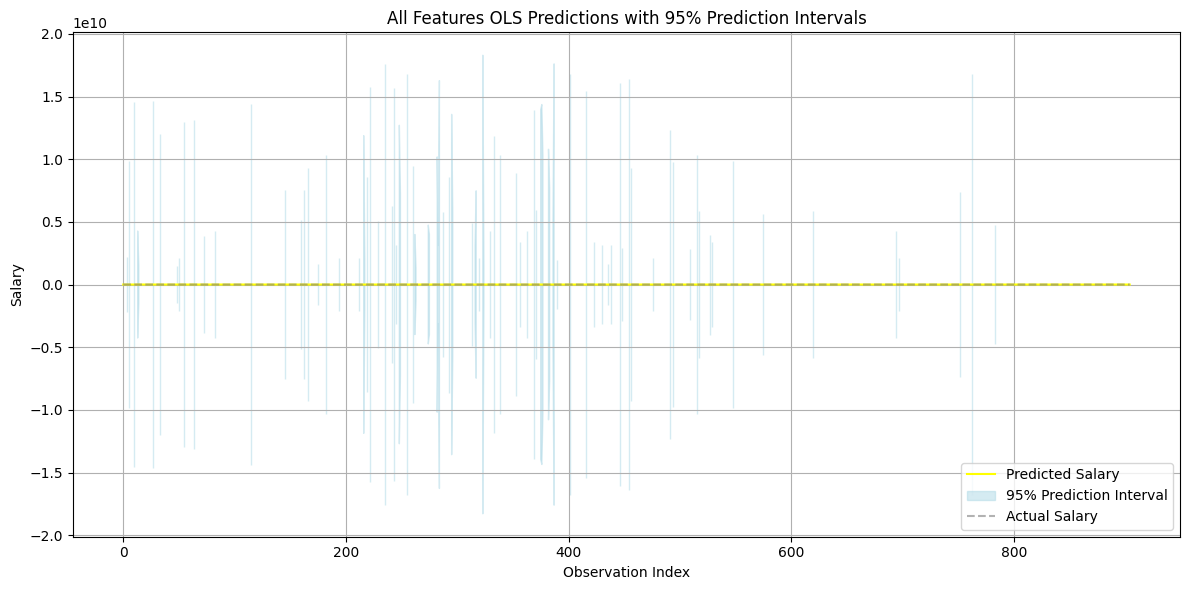

In [431]:
# Extract values from the prediction summary
predicted_all_features = pred_multi_summary["mean"]
lower_all_features = pred_multi_summary["obs_ci_lower"]
upper_all_features = pred_multi_summary["obs_ci_upper"]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(predicted_all_features, label="Predicted Salary", color="yellow")
plt.fill_between(range(len(predicted_all_features)), lower_all_features, upper_all_features, color="lightblue", alpha=0.5, label="95% Prediction Interval")

# Optional: overlay actual salaries
plt.plot(y.values, label="Actual Salary", color="grey", linestyle="--", alpha=0.6)

# Customize the plot
plt.xlabel("Observation Index")
plt.ylabel("Salary")
plt.title("All Features OLS Predictions with 95% Prediction Intervals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<p>Using every single variable after one hot endcoding made a model that predicted quite well. However, the confidence intervals are really big, which makes me think the OLS overfitted to the data, and there is a multicollinearity issue.</p>

In [399]:
print(predicted_all_features.head(5))
print(y.values)

0    134288.084917
1    150508.927650
2    165092.075589
3    162821.143202
4    253652.707217
Name: mean, dtype: float64
[ 138918.   148909.5  179711.   200367.5  261811.5   71062.   148543.5
  242577.   256465.   113274.    88914.   155269.5  134647.   162961.5
  157091.    61713.   190214.   242043.5   93744.    84955.   151799.5
   99501.   208386.    11757.   117547.5  175740.5  176327.   245783.
   84843.   131377.   154951.    64119.   131380.    32840.   121823.
  273570.   304447.   133795.   200368.   122891.   187011.5  164573.
   86275.   177927.   267363.   173655.5  227704.5  155162.5  256467.5
   90305.5  184341.   288521.    48323.    90278.5  121158.5   36475.
   68906.    31306.   173653.   174105.   172907.5   28320.    16247.
  207847.5  119535.5  180548.   121163.5  358749.    33346.   299206.
  187006.   113278.   256465.    42518.   162435.   136250.   235095.
  213187.5  103176.   267687.5  192347.5  203033.   230249.5  168844.
  201965.    96374.   262986.   19

<p>These predictions are quite good, especially the r-squared score. However, the confidence intervals are all off, meaning the model doesn't know how it came to those predictions. I </p>

<p>I thought that company revenue would be a good independent variable to use for a simple regression. My prediction is that if a company makes lots of money then there should be a direct positive impact on salary.</p>
<p>Also, in the above sm.OLS summary, the numerical features had lower p-values, and acceptable confidence intervals, so I want to see if the model's performance improves when using those.</p>

In [ ]:
# Simple regression
X_simple = sm.add_constant(X["revenue_num"])
y_simple = y

# Fit model
model_simple = sm.OLS(y_simple, X_simple).fit()
pred_simple = model_simple.get_prediction(X_simple)
intervals_simple = pred_simple.summary_frame(alpha=0.05)

print(model_simple.summary())

                            OLS Regression Results                            
Dep. Variable:             salary_num   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.330
Date:                Wed, 08 Oct 2025   Prob (F-statistic):              0.127
Time:                        14:33:49   Log-Likelihood:                -12085.
No. Observations:                 905   AIC:                         2.417e+04
Df Residuals:                     903   BIC:                         2.418e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.516e+05   5437.315     27.888      

<p>Looks like the model is pretty bad. F-statistic is low, R-squared value is low, the confidence interval includes 0, and my p-value is not less than 0.05.</p>
<p>This simple regression will not do a good job at predicting salary.</p>

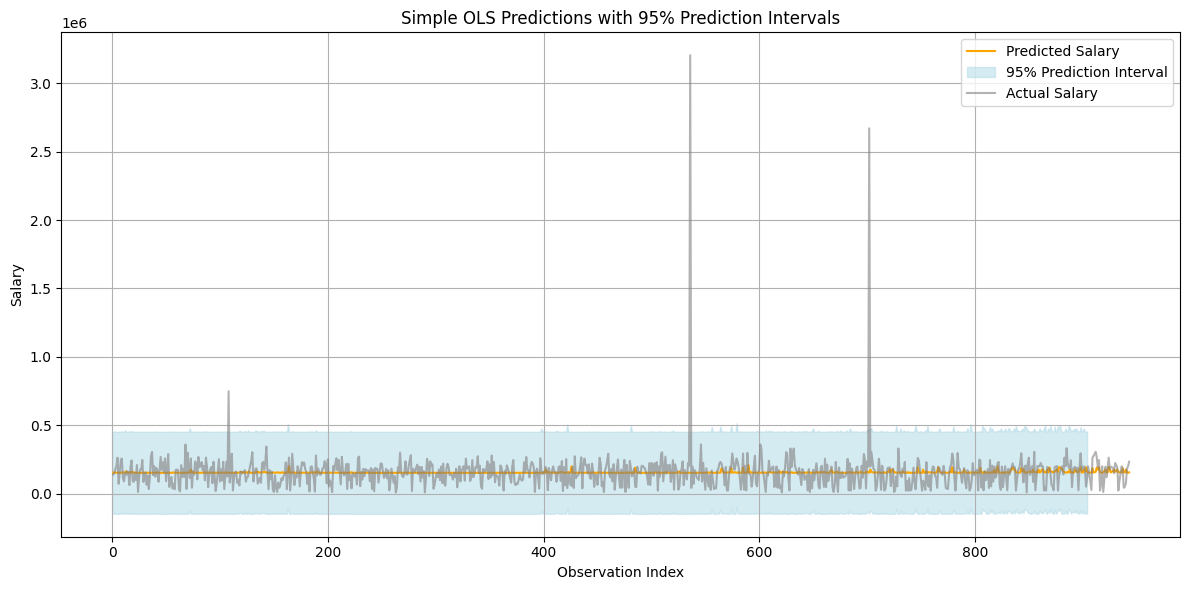

In [424]:
# Extract values from the prediction summary
predicted_simple = intervals_simple["mean"]
lower_simple = intervals_simple["obs_ci_lower"]
upper_simple = intervals_simple["obs_ci_upper"]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(predicted_simple, label="Predicted Salary", color="orange")
plt.fill_between(range(len(predicted_simple)), lower_simple, upper_simple, color="lightblue", alpha=0.5, label="95% Prediction Interval")

# Optional: overlay actual salaries
plt.plot(y_simple, label="Actual Salary", color="grey", alpha=0.6)

# Customize the plot
plt.xlabel("Observation Index")
plt.ylabel("Salary")
plt.title("Simple OLS Predictions with 95% Prediction Intervals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [403]:
predicted_simple
y_simple.head(5)

print('predicted points from simple model: \n', predicted_simple.head(5))
print('actual salary points for simple model: \n', y_simple.head(5))

predicted points from simple model: 
 1    153082.020808
2    152591.694687
3    153949.586274
4    151633.716486
5    151694.936394
Name: mean, dtype: float64
actual salary points for simple model: 
 1    138918.0
2    148909.5
3    179711.0
4    200367.5
5    261811.5
Name: salary_num, dtype: float64


<p>Wow. My model is quite awful.</p>
<p>It is way to rigid and underfit to the data. This must be because it only had the company's revenue to go off of.</p>

In [414]:
df_multi = df.dropna(subset=["days_since_post"])
y_multi = df_multi['salary_num']

<p>Next, since the numerical features seem to offer better inference this next model will only use the three numerical features in this dataset.</p>

In [ ]:
# Multiple regression only numerical
X_multi = sm.add_constant(df_multi[["revenue_num", "company_size_num", "days_since_post"]])
model_multi = sm.OLS(y_multi, X_multi).fit()
pred_multi = model_multi.get_prediction(X_multi)
intervals_multi = pred_multi.summary_frame(alpha=0.05)

In [413]:
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             salary_num   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     6.666
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           0.000188
Time:                        14:38:14   Log-Likelihood:                -12011.
No. Observations:                 900   AIC:                         2.403e+04
Df Residuals:                     896   BIC:                         2.405e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.595e+05   6164.808  

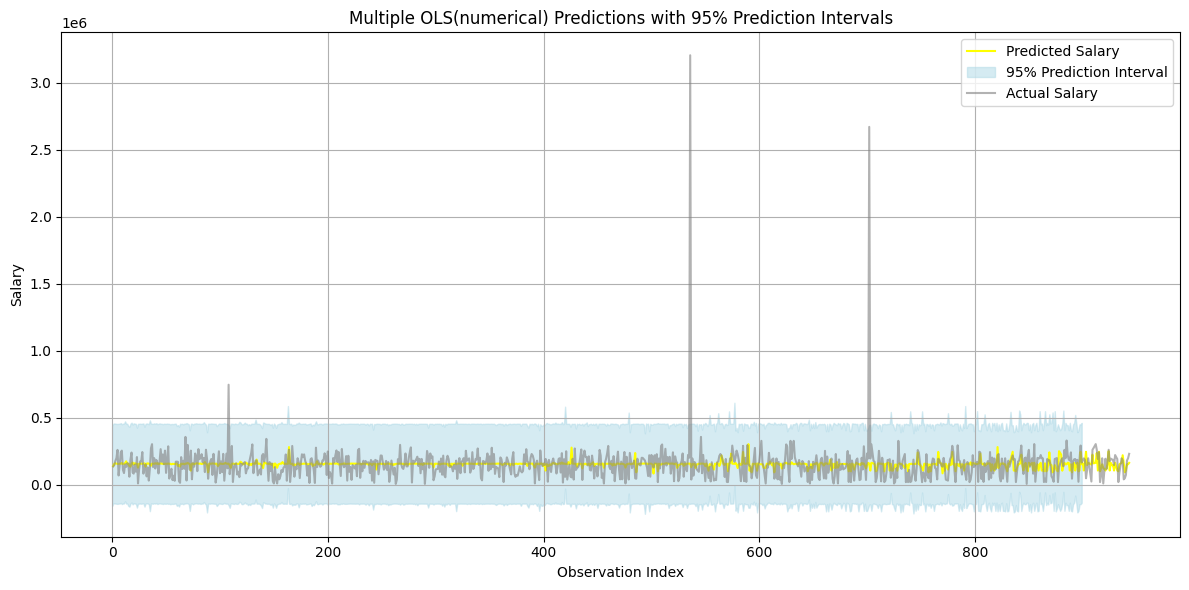

In [425]:
# Extract values from the prediction summary
predicted = intervals_multi["mean"]
lower = intervals_multi["obs_ci_lower"]
upper = intervals_multi["obs_ci_upper"]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(predicted, label="Predicted Salary", color="yellow")
plt.fill_between(range(len(predicted)), lower, upper, color="lightblue", alpha=0.5, label="95% Prediction Interval")

# Optional: overlay actual salaries
plt.plot(y_multi, label="Actual Salary", color="grey", alpha=0.6)

# Customize the plot
plt.xlabel("Observation Index")
plt.ylabel("Salary")
plt.title("Multiple OLS(numerical) Predictions with 95% Prediction Intervals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<p>This model is slightly better than the simple numerical regression model, but it still does quite a bad job.</p>
<p>Perhaps with some feature engineering like getting rid of outliers, and incorrporating some key categorical variables, would result in a robust model.</p>

<h3>(2) Make a plot showing the predicted regression line from your simple regression with the dependent variable on the y-axis and independent variable on the x-axis. Also display prediction interval lines. (The easiest way to do this is probably starting by generating x-values from x-min to x-max, then getting predicted y's for that set. Then generate lower and upper prediction interval bounds for each x in the set. Note that the statistics, e.g., /bar{x}, should still be calculated using the collected data.)</h3>

In [408]:
# todo